## Step 3: Prediction Model (WITH PCA features)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone as clone_model
import time

# Start timer
start_time = time.time()


In [12]:
df = pd.read_excel("df_after_pca.xlsx")


## Model


### Preprocessing


In [13]:
# Select only the most important features from PCA
selected_features = [
    'PC1',
    'PC2',
    'PC3',
    'PC4',
    'PC5',
    'PC6'
]

# Create feature matrix X and target variable y
X = df[selected_features]
y = df['HomeWin']

# Print dataset information
print(f"Train dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")


Train dataset shape: (4323, 6)
Target distribution:
HomeWin
0    0.54985
1    0.45015
Name: proportion, dtype: float64


In [14]:
# Split the data into training and testing sets FIRST
# This ensures we keep our test set completely separate from any training/validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a scaler but don't fit it yet - we'll fit it in the cross-validation process
scaler = StandardScaler()

# Save feature names for later use
feature_names = X.columns


### Machine Learning Models

Train and evaluate multiple machine learning models
We will test 4 different models:
- Decision Tree: A simple tree-based model
- Random Forest: An ensemble of decision trees  
- Support Vector Machine (SVM): A powerful classifier that works well with scaled data
- K-Nearest Neighbors (KNN): A distance-based classifier


In [15]:
# Initialize models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=10)
lr_model = LogisticRegression(random_state=42)

# Create a list of models
models = [
    ('Decision Tree', dt_model),
    ('Random Forest', rf_model),
    ('SVM', svm_model),
    ('KNN', knn_model),
    ('Logistic Regression', lr_model)
]

# Create empty lists to store metrics
model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
auc_scores = []

# Create dictionary to store trained models from cross-validation
trained_models = {}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model using cross-validation
for name, model in models:
    # Lists to store metrics for each fold
    cv_accuracies = []
    cv_precisions = []
    cv_recalls = []
    cv_f1s = []
    cv_aucs = []
    
    # Create a copy of the model to use for final training
    final_model = clone_model(model)
    
    # Perform cross-validation ON TRAINING DATA ONLY
    for train_idx, val_idx in cv.split(X_train, y_train):
        # Split data for this fold
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Scale features properly: fit only on training fold, transform both
        fold_scaler = StandardScaler()
        X_train_fold_scaled = pd.DataFrame(fold_scaler.fit_transform(X_train_fold), columns=X_train_fold.columns)
        X_val_fold_scaled = pd.DataFrame(fold_scaler.transform(X_val_fold), columns=X_val_fold.columns)
        
        # Train the model
        model.fit(X_train_fold_scaled, y_train_fold)
        
        # Make predictions
        y_pred = model.predict(X_val_fold_scaled)
        
        # Get probabilities for positive class (for AUC calculation)
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_val_fold_scaled)[:,1]
        else:
            # For models that don't have predict_proba
            y_probs = model.decision_function(X_val_fold_scaled)
        
        # Calculate metrics for this fold
        cv_accuracies.append(accuracy_score(y_val_fold, y_pred))
        cv_precisions.append(precision_score(y_val_fold, y_pred))
        cv_recalls.append(recall_score(y_val_fold, y_pred))
        cv_f1s.append(f1_score(y_val_fold, y_pred))
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_val_fold, y_probs)
        roc_auc = auc(fpr, tpr)
        cv_aucs.append(roc_auc)
    
    # Calculate average metrics across all folds
    model_names.append(name)
    accuracies.append(np.mean(cv_accuracies))
    precisions.append(np.mean(cv_precisions))
    recalls.append(np.mean(cv_recalls))
    f1_scores.append(np.mean(cv_f1s))
    auc_scores.append(np.mean(cv_aucs))
    
    # Now train the final model on the entire training set
    X_train_scaled = scaler.fit_transform(X_train)
    final_model.fit(X_train_scaled, y_train)
    
    # Store the trained model for later use
    trained_models[name] = final_model

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions, 
    'Recall': recalls,
    'F1 Score': f1_scores,
    'AUC': auc_scores
})

# Style the DataFrame
styled_df = results_df.style\
    .background_gradient(cmap='RdYlGn')\
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1 Score': '{:.4f}',
        'AUC': '{:.4f}'
    })\
    .set_caption('Model Performance Comparison (5-Fold Cross-Validation)')

display(styled_df)


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree,0.5604,0.5171,0.5368,0.5267,0.5585
1,Random Forest,0.6275,0.6048,0.5305,0.5650,0.6670
2,SVM,0.6455,0.6489,0.4848,0.5549,0.6831
3,KNN,0.6070,0.5981,0.4239,0.4958,0.6350
4,Logistic Regression,0.6530,0.6397,0.5470,0.5893,0.7047


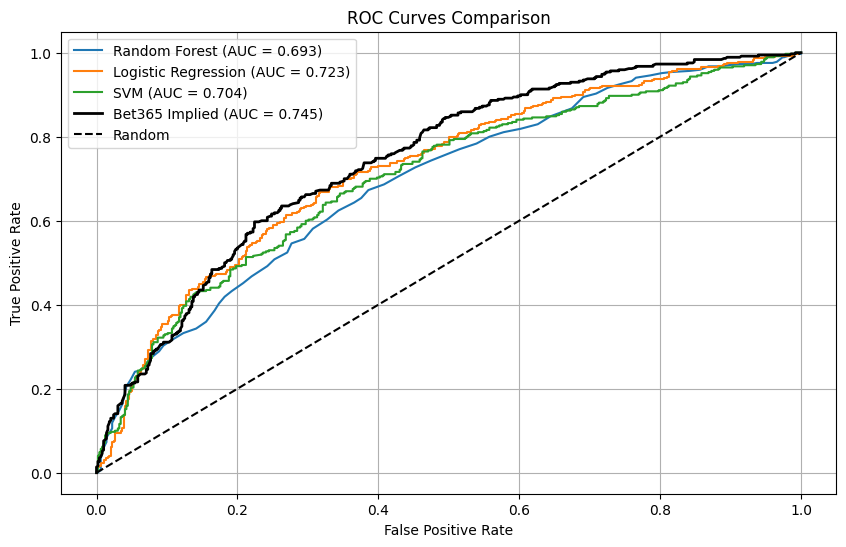


AUC Scores:
Random Forest: 0.6928
Logistic Regression: 0.7234
SVM: 0.7041
Bet365 Implied: 0.7451


In [16]:
# Scale the test set using the scaler fit on the entire training data
X_test_scaled = scaler.transform(X_test)

# Get predictions from our trained models
rf_model = trained_models['Random Forest']
lr_model = trained_models['Logistic Regression']
svm_model = trained_models['SVM'] 

# Get probabilities for positive class
rf_probs = rf_model.predict_proba(X_test_scaled)[:,1]
lr_probs = lr_model.predict_proba(X_test_scaled)[:,1]
svm_probs = svm_model.predict_proba(X_test_scaled)[:,1]

# Get Bet365's implied probability for home win
bet365_probs = df.loc[y_test.index, 'B365H_prob'].values

# Calculate ROC curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
bet365_fpr, bet365_tpr, _ = roc_curve(y_test, bet365_probs)

# Calculate AUC scores
rf_auc = auc(rf_fpr, rf_tpr)
lr_auc = auc(lr_fpr, lr_tpr)
svm_auc = auc(svm_fpr, svm_tpr)
bet365_auc = auc(bet365_fpr, bet365_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.3f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.3f})')
plt.plot(bet365_fpr, bet365_tpr, color='black', linestyle='-', linewidth=2, 
         label=f'Bet365 Implied (AUC = {bet365_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print AUC scores
print("\nAUC Scores:")
print(f"Random Forest: {rf_auc:.4f}")
print(f"Logistic Regression: {lr_auc:.4f}")
print(f"SVM: {svm_auc:.4f}")
print(f"Bet365 Implied: {bet365_auc:.4f}")


### Deep Learning Models


In [17]:
from sklearn.neural_network import MLPClassifier


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree,0.5604,0.5171,0.5368,0.5267,0.5585
1,Random Forest,0.6275,0.6048,0.5305,0.5650,0.6670
2,SVM,0.6455,0.6489,0.4848,0.5549,0.6831
3,KNN,0.6070,0.5981,0.4239,0.4958,0.6350
4,Logistic Regression,0.6530,0.6397,0.5470,0.5893,0.7047
5,Neural Network,0.6659,0.6209,0.5622,0.5901,0.7171
6,Bet365 Implied,0.6497,0.5599,0.8459,0.6738,0.7451


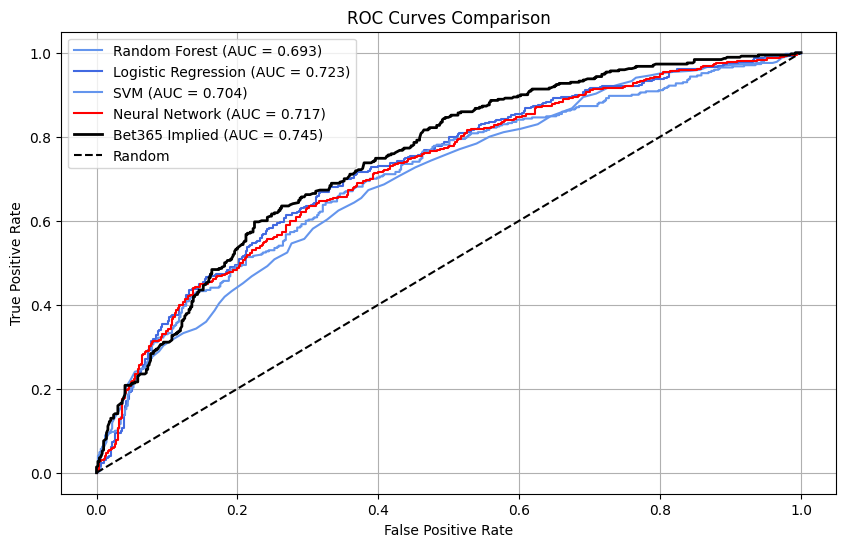


AUC Scores:
Random Forest: 0.6928
Logistic Regression: 0.7234
SVM: 0.7041
Neural Network: 0.7171
Bet365 Implied: 0.7451


In [18]:
# Create and train the MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',             # logistic activation function
    solver='adam',                 # Adam optimizer
    alpha=0.0001,                  # L2 regularization term
    batch_size='auto',             # Automatic batch size
    learning_rate='adaptive',      # Adaptive learning rate
    max_iter=1000,                 # Maximum number of iterations
    early_stopping=True,           # Use early stopping
    validation_fraction=0.1,       # 10% of training data for validation
    n_iter_no_change=10,           # Stop if no improvement after 10 iterations
    random_state=42                # For reproducibility
)

# Train the model on the scaled training data
mlp.fit(X_train_scaled, y_train)

# Make predictions
mlp_probs = mlp.predict_proba(X_test_scaled)[:, 1]
mlp_pred = mlp.predict(X_test_scaled)

# Calculate ROC curve and AUC score
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_probs)
mlp_auc = auc(mlp_fpr, mlp_tpr)

# Calculate metrics for MLP
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred)

# Store the MLP model for later use
trained_models['Neural Network'] = mlp

# Calculate metrics for Bet365 implied probabilities
bet365_probs = df.loc[y_test.index, 'B365H_prob'].values

# Find optimal threshold for Bet365 classification (maximize f1-score)
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_threshold = 0.5  # default threshold

for threshold in thresholds:
    bet365_pred = (bet365_probs >= threshold).astype(int)
    f1 = f1_score(y_test, bet365_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Use best threshold to make predictions
bet365_pred = (bet365_probs >= best_threshold).astype(int)
bet365_accuracy = accuracy_score(y_test, bet365_pred)
bet365_precision = precision_score(y_test, bet365_pred)
bet365_recall = recall_score(y_test, bet365_pred)
bet365_f1 = f1_score(y_test, bet365_pred)

# Add MLP and Bet365 to the results DataFrame
results_df_with_all = pd.DataFrame({
    'Model': model_names + ['Neural Network', 'Bet365 Implied'],
    'Accuracy': accuracies + [mlp_accuracy, bet365_accuracy],
    'Precision': precisions + [mlp_precision, bet365_precision], 
    'Recall': recalls + [mlp_recall, bet365_recall],
    'F1 Score': f1_scores + [mlp_f1, bet365_f1],
    'AUC': auc_scores + [mlp_auc, bet365_auc]
})

# Style the DataFrame
styled_df_with_all = results_df_with_all.style\
    .background_gradient(cmap='RdYlGn')\
    .format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1 Score': '{:.4f}',
        'AUC': '{:.4f}'
    })\
    .set_caption('Model Performance Comparison (Including Neural Network and Bet365)')

display(styled_df_with_all)

# Add MLP to the ROC curve comparison
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, color='#6495ED', label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot(lr_fpr, lr_tpr, color='#4169E1', label=f'Logistic Regression (AUC = {lr_auc:.3f})')
plt.plot(svm_fpr, svm_tpr, color='#6495ED', label=f'SVM (AUC = {svm_auc:.3f})')
plt.plot(mlp_fpr, mlp_tpr, color='red', label=f'Neural Network (AUC = {mlp_auc:.3f})')
plt.plot(bet365_fpr, bet365_tpr, color='black', linestyle='-', linewidth=2, 
         label=f'Bet365 Implied (AUC = {bet365_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print AUC scores
print("\nAUC Scores:")
print(f"Random Forest: {rf_auc:.4f}")
print(f"Logistic Regression: {lr_auc:.4f}")
print(f"SVM: {svm_auc:.4f}")
print(f"Neural Network: {mlp_auc:.4f}")
print(f"Bet365 Implied: {bet365_auc:.4f}")


### Extra: Using the model predictions to build a betting strategy

Placing a bet for the Home Team Win whenever the model probability is greather than the Bet365 Implied probability multiplied by a minimum margin.



Betting Strategy Results:

Random Forest:
Wins: 106 (51.21% win rate)
Profit: $-79.20
ROI: -7.92%

Logistic Regression:
Wins: 88 (56.77% win rate)
Profit: $85.50
ROI: 8.55%

SVM:
Wins: 71 (53.38% win rate)
Profit: $-28.20
ROI: -2.82%

Neural Network:
Wins: 84 (59.15% win rate)
Profit: $126.50
ROI: 12.65%

Random Selection 1:
Wins: 58 (40.28% win rate)
Profit: $-256.40
ROI: -25.64%

Random Selection 2:
Wins: 66 (45.83% win rate)
Profit: $-74.90
ROI: -7.49%

Random Selection 3:
Wins: 52 (36.11% win rate)
Profit: $-374.90
ROI: -37.49%


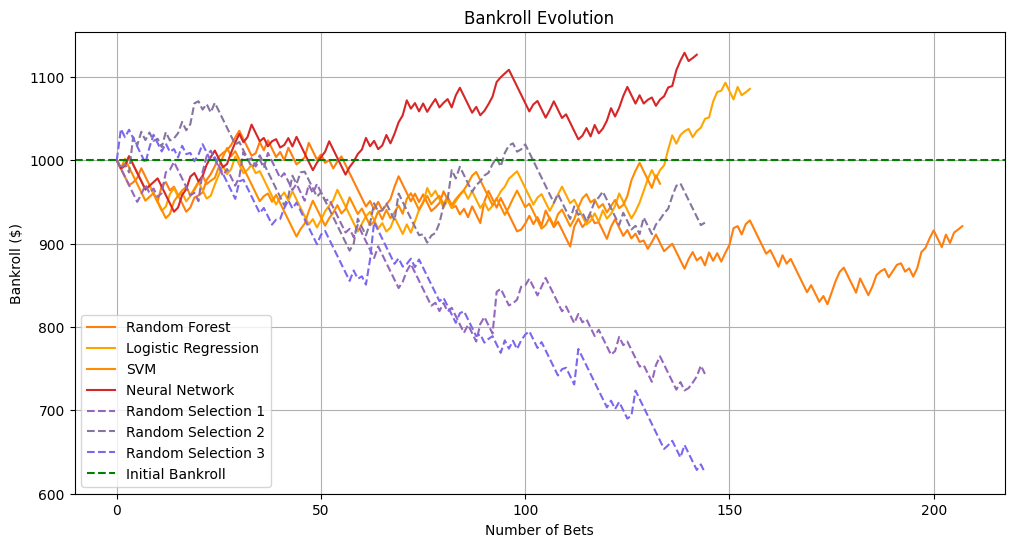

,Model Type,Model,Total Bets,Win Rate (%),Profit ($),ROI (%)
0,Machine Learning,Random Forest,207,51.21,-79.20,-7.92
1,Machine Learning,Logistic Regression,155,56.77,85.50,8.55
2,Machine Learning,SVM,133,53.38,-28.20,-2.82
3,Deep Learning,Neural Network,142,59.15,126.50,12.65
4,Random Selection,Random Selection 1,144,40.28,-256.40,-25.64
5,Random Selection,Random Selection 2,144,45.83,-74.90,-7.49
6,Random Selection,Random Selection 3,144,36.11,-374.90,-37.49


In [19]:
# Betting Strategy Simulation

# Min Bet Margin 
min_bet_margin = 0.05

# Get the odds and probabilities, ensure they're properly aligned with test set
bet365_odds = np.array([df.loc[idx, 'B365H'] for idx in y_test.index])
bet365_implied_probs = np.array([df.loc[idx, 'B365H_prob'] for idx in y_test.index])

# Define random seeds for different random betting strategies
random_seeds = [42, 123, 456]

# Initialize results dictionary
betting_results = {
    'Random Forest': {'bets': 0, 'wins': 0, 'losses': 0, 'profit': 0, 'roi': 0},
    'Logistic Regression': {'bets': 0, 'wins': 0, 'losses': 0, 'profit': 0, 'roi': 0},
    'SVM': {'bets': 0, 'wins': 0, 'losses': 0, 'profit': 0, 'roi': 0},
    'Neural Network': {'bets': 0, 'wins': 0, 'losses': 0, 'profit': 0, 'roi': 0},
    'Random Selection 1': {'bets': 0, 'wins': 0, 'losses': 0, 'profit': 0, 'roi': 0},
    'Random Selection 2': {'bets': 0, 'wins': 0, 'losses': 0, 'profit': 0, 'roi': 0},
    'Random Selection 3': {'bets': 0, 'wins': 0, 'losses': 0, 'profit': 0, 'roi': 0}
}

# Betting parameters
initial_bankroll = 1000  # Starting with $1000
fixed_stake = 10         # Fixed stake of $10 per bet

# Helper function to process a bet regardless of strategy
def process_bet(model_name, index, bankroll):
    stake = fixed_stake
    betting_results[model_name]['bets'] += 1
    
    # Check if it's a win (home team won)
    if y_test.iloc[index] == 1:
        # Win: get stake back plus winnings
        winnings = stake * (bet365_odds[index] - 1)
        bankroll += winnings
        betting_results[model_name]['wins'] += 1
        return bankroll, (index, stake, winnings, bankroll)
    else:
        # Loss: lose stake
        bankroll -= stake
        betting_results[model_name]['losses'] += 1
        return bankroll, (index, stake, -stake, bankroll)

# Function to simulate betting for ML models
def simulate_betting(model_probs, model_name):
    bankroll = initial_bankroll
    bet_history = []
    
    for i in range(len(y_test)):
        # Only bet when model probability is higher than bookmaker's implied probability
        if model_probs[i] > bet365_implied_probs[i]*(1 + min_bet_margin) and model_probs[i] > 0.5:
            bankroll, bet_record = process_bet(model_name, i, bankroll)
            bet_history.append(bet_record)
    
    # Calculate profit and ROI
    betting_results[model_name]['profit'] = bankroll - initial_bankroll
    betting_results[model_name]['roi'] = (bankroll / initial_bankroll - 1) * 100
    
    return bet_history

# Function to simulate random betting strategy
def simulate_random_betting(model_name, seed=42):
    bankroll = initial_bankroll
    bet_history = []
    
    # Randomly select matches to bet on
    np.random.seed(seed)
    bet_indices = np.random.choice(len(y_test), size=len(y_test)//6, replace=False)
    
    for i in bet_indices:
        bankroll, bet_record = process_bet(model_name, i, bankroll)
        bet_history.append(bet_record)
    
    # Calculate profit and ROI
    betting_results[model_name]['profit'] = bankroll - initial_bankroll
    betting_results[model_name]['roi'] = (bankroll / initial_bankroll - 1) * 100
    
    return bet_history

# Run simulations
model_histories = {
    'Random Forest': simulate_betting(rf_probs, 'Random Forest'),
    'Logistic Regression': simulate_betting(lr_probs, 'Logistic Regression'),
    'SVM': simulate_betting(svm_probs, 'SVM'),
    'Neural Network': simulate_betting(mlp_probs, 'Neural Network')
}

# Run random betting simulations with different seeds
random_bet_histories = []
for i, seed in enumerate(random_seeds):
    model_name = f'Random Selection {i+1}'
    random_bet_histories.append(simulate_random_betting(model_name, seed=seed))

# Display results
print("\nBetting Strategy Results:")
for model, results in betting_results.items():
    print(f"\n{model}:")
    win_rate_str = f"Wins: {results['wins']} ({results['wins']/results['bets']*100:.2f}% win rate)" if results['bets'] > 0 else "Wins: 0 (0.00% win rate)"
    print(win_rate_str)
    print(f"Profit: ${results['profit']:.2f}")
    print(f"ROI: {results['roi']:.2f}%")

# Plot bankroll evolution with custom colors
plt.figure(figsize=(12, 6))

# Define color scheme
orange_shades = ['#ff7f0e', '#FFA500', '#FF8C00']  # Shades of orange for ML models
red_color = '#d62728'  # Red for deep learning model
purple_shades = ['#9467bd', '#8674A1', '#7B68EE']  # Shades of purple for random selections

# Plot ML and Neural Network model bankrolls
for i, (model_name, history) in enumerate(model_histories.items()):
    if history:
        if model_name == 'Neural Network':
            color = red_color
        else:
            color = orange_shades[i % len(orange_shades)]
        
        bankroll = [initial_bankroll] + [bet[3] for bet in history]
        plt.plot(range(len(bankroll)), bankroll, label=model_name, color=color)

# Plot random selection bankrolls
for i, history in enumerate(random_bet_histories):
    if history:
        random_bankroll = [initial_bankroll] + [bet[3] for bet in history]
        plt.plot(range(len(random_bankroll)), random_bankroll, 
                 label=f'Random Selection {i+1}', 
                 color=purple_shades[i], 
                 linestyle='--')

plt.axhline(y=initial_bankroll, color='green', linestyle='--', label='Initial Bankroll')
plt.xlabel('Number of Bets')
plt.ylabel('Bankroll ($)')
plt.title('Bankroll Evolution')
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame with betting results for better visualization
results_table = {
    'Model Type': [],
    'Model': [],
    'Total Bets': [],
    'Win Rate (%)': [],
    'Profit ($)': [],
    'ROI (%)': []
}

for model, results in betting_results.items():
    # Determine model type based on model name
    model_type = 'Random Selection' if 'Random Selection' in model else ('Deep Learning' if model == 'Neural Network' else 'Machine Learning')
    
    # Calculate win rate safely
    win_rate = results['wins']/results['bets']*100 if results['bets'] > 0 else 0
    
    # Add all data to the results table
    results_table['Model Type'].append(model_type)
    results_table['Model'].append(model)
    results_table['Total Bets'].append(results['bets'])
    results_table['Win Rate (%)'].append(win_rate)
    results_table['Profit ($)'].append(results['profit'])
    results_table['ROI (%)'].append(results['roi'])

# Convert to DataFrame and style it
results_df = pd.DataFrame(results_table)
styled_df = results_df.style\
    .background_gradient(subset=['Win Rate (%)', 'Profit ($)', 'ROI (%)'], cmap='RdYlGn')\
    .set_properties(**{'text-align': 'center'})\
    .format({
        'Win Rate (%)': '{:.2f}',
        'Profit ($)': '{:.2f}',
        'ROI (%)': '{:.2f}'
    })\
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f2f2f2'), 
                  ('color', 'black'),
                  ('font-weight', 'bold'),
                  ('text-align', 'center')]
    }])\
    .set_caption('Betting Strategy Performance Comparison')

display(styled_df)


In [20]:
# End timer
end_time = time.time()

# Print execution time
print(f"Execution Time: {(end_time - start_time):.2f} seconds")


Execution Time: 27.18 seconds


This project set out to explore whether football match outcomes can be predicted using features derived from team's recent performances and betting market data. The results showed that models based on these variables, particularly Logistic Regression and a simple neural network, were able to make meaningful and competitive predictions.
The analysis confirmed that recent team form and market expectations carry strong predictive power. While absolute accuracy remains challenging given the unpredictable nature of football, the findings support the idea that historical performance trends and betting odds can be effectively used to forecast match results 